# DDPM


References
- https://huggingface.co/blog/annotated-diffusion
- https://github.com/cloneofsimo/minDiffusion
- https://github.com/milesial/Pytorch-UNet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = T.Compose([
    T.Resize((32,32)),
    T.ToTensor(),                      # [ 0.0, 1.0]
    T.Lambda(lambda t: (t * 2) - 1),   # [-1.0, 1.0]
])

reverse_transform = T.Compose([
    T.Lambda(lambda t: (t + 1) / 2),                 # reverse of (t * 2) - 1
    T.Lambda(lambda t: torch.clamp(t, 0, 1)),        # [0.0, 1.0]
    T.Lambda(lambda t: t.permute(1, 2, 0)),          # CHW -> HWC
    T.Lambda(lambda t: t * 255.),                    # [0.0, 255.0]
    T.Lambda(lambda t: t.numpy().astype(np.uint8)),  # [0, 255]
    T.ToPILImage(),                                  # Array -> PIL
])

In [ ]:
dataset = MNIST(root='./data', train=True, download=True, transform=transform)

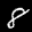

In [ ]:
idx = -1
sample = dataset[idx][0]
reverse_transform(sample)

In [ ]:
def diffusion_schedule(beta_1=0.0001, beta_T=0.02, T=1000):
  beta_t = beta_1 + (beta_T - beta_1) * torch.arange(0, T) / T

  sqrt_beta_t = torch.sqrt(beta_t)

  alpha_t = 1 - beta_t
  alpha_bar_t = torch.cumprod(alpha_t, dim=0)

  sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
  sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

  one_over_sqrt_alpha_t = 1 / torch.sqrt(alpha_t)
  one_minus_alpha_t_over_sqrt_one_minus_alpha_bar_t = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)

  return {
      "beta_t": beta_t,
      "sqrt_beta_t": sqrt_beta_t,
      "alpha_t": alpha_t,
      "alpha_bar_t": alpha_bar_t,
      "sqrt_alpha_bar_t": sqrt_alpha_bar_t,
      "sqrt_one_minus_alpha_bar_t": sqrt_one_minus_alpha_bar_t,
      "one_over_sqrt_alpha_t": one_over_sqrt_alpha_t,
      "one_minus_alpha_t_over_sqrt_one_minus_alpha_bar_t": one_minus_alpha_t_over_sqrt_one_minus_alpha_bar_t
  }

In [ ]:
def q_sample(x_0, t):
  schedule = diffusion_schedule()

  # eps ~ N(0, 1)
  eps = torch.randn_like(x_0)

  sqrt_alpha_bar_t = schedule["sqrt_alpha_bar_t"][t]
  sqrt_one_minus_alpha_bar_t = schedule["sqrt_one_minus_alpha_bar_t"][t]

  # x_t ~ q(x_t | x_0)
  return sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * eps

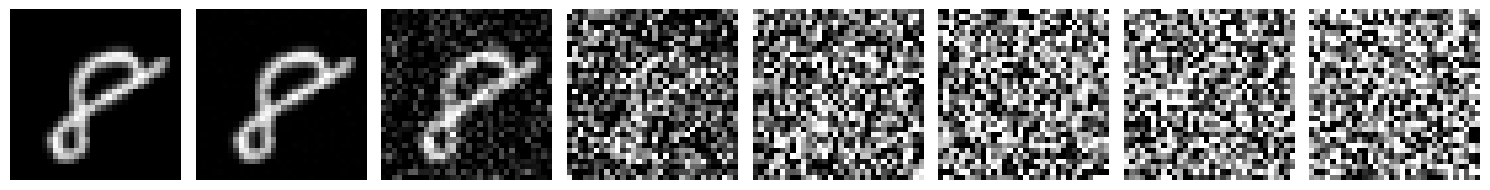

In [ ]:
def get_noisy_image(x_0, t):
  x_t = q_sample(x_0, t)
  return reverse_transform(x_t)

xt_list = [reverse_transform(sample)] + [get_noisy_image(sample, t) for t in [0, 100, 300, 500, 700, 900, 999]]

def draw_images(imgs, save_path=None, figsize=(15, 5)):
  num_cols = len(imgs)
  fig, axs = plt.subplots(figsize=figsize, ncols=num_cols)
  for i, ax in enumerate(axs):
    ax.imshow(imgs[i], cmap='gray' if len(imgs[i].size)==2 else None)
    ax.axis('off')
  plt.tight_layout()
  if save_path:
    plt.savefig(save_path, dpi=300)
  else:
    plt.show()

draw_images(xt_list)

In [ ]:
class DDPM(nn.Module):
  def __init__(self, eps_model, betas=[0.0001, 0.02], T=1000, criterion=nn.MSELoss()):
    super().__init__()
    self.eps_model = eps_model

    for k, v in diffusion_schedule(betas[0], betas[1], T).items():
      self.register_buffer(k, v)

    self.T = T
    self.criterion = criterion


  def forward(self, x):
    # x : x_0
    # (B, C, H, W)

    # t ~ Uniform({0, 1, ..., T-1})
    # (B,)
    t = torch.randint(0, self.T, (x.shape[0],)).to(x.device)

    # eps ~ N(0, 1)
    # (B, C, H, W)
    eps = torch.randn_like(x)

    # x_t ~ q(x_t | x_0)
    # (B, C, H, W)
    x_t = self.sqrt_alpha_bar_t[t][:, None, None, None] * x + self.sqrt_one_minus_alpha_bar_t[t][:, None, None, None] * eps

    # loss = |eps - eps_model(x_t, t)|
    return self.criterion(eps, self.eps_model(x_t, t/self.T))


  def sample(self, n_sample, size, device):
    with torch.inference_mode():
      # x_T ~ N(0, 1)
      # (n_sample, C, H, W)
      x_t = torch.randn(n_sample, *size).to(device)

      # t=T-1, ... , 0
      for t in reversed(range(0, self.T)):
        # z ~ N(0, 1)
        # (n_sample, C, H, W)
        z = torch.randn_like(x_t) if t > 0 else 0

        # predicted noise
        eps = self.eps_model(
          x_t, torch.tensor(t/self.T).to(device).repeat(n_sample, 1)
        )
        x_t = self.one_over_sqrt_alpha_t[t] * (x_t - self.one_minus_alpha_t_over_sqrt_one_minus_alpha_bar_t[t] * eps) + self.sqrt_beta_t[t] * z

      return x_t

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.GroupNorm(8, out_channels),
      nn.ReLU(),

      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.GroupNorm(8, out_channels),
      nn.ReLU()
    )

  def forward(self, x):
    # x : (B, C_in, H, W)

    # (B, C_out, H, W)
    return self.model(x)
  
  
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.down = nn.MaxPool2d(2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x):
    # x : (B, C_in, H, W)

    # (B, C_in, H//2, W//2)
    x = self.down(x)

    # (B, C_out, H//2, W//2)
    return self.conv(x)


class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(out_channels, out_channels)

  def forward(self, x, skip):
    # x    : (B, C_in//2, H, W)
    # skip : (B, C_in//2, H, W)

    # (B, C_in, H, W)
    x = torch.cat([x, skip], dim=1)
    
    # (B, C_out, H*2, W*2)
    x = self.up(x)

    # (B, C_out, H*2, W*2)
    return self.conv(x)
  

class TimeEmbedding(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.lin1 = nn.Linear(1, emb_dim, bias=False)
    self.lin2 = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    # x : (B,)
    
    # (B, 1)
    x = x.view(-1, 1)

    # (B, emb_dim)
    x = self.lin1(x)
    x = torch.sin(x)

    # (B, emb_dim)
    x = self.lin2(x)
    return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_feat=256):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.n_feat = n_feat

        #-----------------------------------------------------------
        # [B, C, H, W] -> [B, n_feat, H, W]
        self.init_conv1 = DoubleConv(in_channels, n_feat)
        # [B, n_feat, H, W] -> [B, n_feat, H, W]
        self.init_conv2 = DoubleConv(n_feat, n_feat)

        
        # [B, n_feat, H, W] -> [B, n_feat, H//2, W//2]
        self.down1 = Down(n_feat, n_feat)
        # [B, n_feat, H//2, W//2] -> [B, 2*n_feat, H//4, W//4]
        self.down2 = Down(n_feat, 2*n_feat)
        # [B, 2*n_feat, H//4, W//4] -> [B, 2*n_feat, H//8, W//8]
        self.down3 = Down(2*n_feat, 2*n_feat)

        # [B, 4*n_feat, H//8, W//8] -> [B, 2*n_feat, H//4, W//4]
        self.up1 = Up(4*n_feat, 2*n_feat)
        # [B, 4*n_feat, H//4, W//4] -> [B, n_feat, H//2, W//2]
        self.up2 = Up(4*n_feat, n_feat)
        # [B, 2*n_feat, H//2, W//2] -> [B, n_feat, H, W]
        self.up3 = Up(2*n_feat, n_feat)

        # [B, 2*n_feat, H, W] -> [B, out_channels, H, W]
        self.out = nn.Conv2d(2*n_feat, out_channels, kernel_size=1)
        #-----------------------------------------------------------

        # [B, C, H//8, W//8] -> [B, C, H//32, W//32]
        self.to_vec = nn.Sequential(
            nn.AvgPool2d(4),
            nn.ReLU()
        )
        
        # [B,] -> [B, 2*n_feat]
        self.time_embed = TimeEmbedding(2 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2*n_feat, 2*n_feat, kernel_size=4, stride=4),
            nn.GroupNorm(8, 2*n_feat),
            nn.ReLU()
        )

    
    def forward(self, x, t):
        # x : (B, C, H, W)
        # t : (B,)

        # [B, n_feat, H, W]
        x = self.init_conv1(x)
        # [B, n_feat, H, W]
        x = x + self.init_conv2(x)
        
        # [B, n_feat, H//2, W//2]
        down1 = self.down1(x)
        # [B, 2*n_feat, H//4, W//4]
        down2 = self.down2(down1)
        # [B, 2*n_feat, H//8, W//8]
        down3 = self.down3(down2)

        #===========================================================
        # [B, 2*n_feat, H//32, W//32]
        thro = self.to_vec(down3)

        # [B, 2*n_feat, 1, 1]
        temb = self.time_embed(t).view(-1, 2*self.n_feat, 1, 1)

        # [B, 2*n_feat, H//8, W//8]
        thro = self.up0(thro + temb)
        #===========================================================

        # [B, 2*n_feat, H//4, W//4]
        up1 = self.up1(thro, down3)
        # [B, n_feat, H//2, W//2]
        up2 = self.up2(up1, down2)
        # [B, n_feat, H, W]
        up3 = self.up3(up2, down1)


        # [B, out_channels, H, W]
        out = self.out(torch.cat([up3, x], dim=1))

        return out

In [ ]:
ddpm = DDPM(eps_model=UNet(1, 1, n_feat=128), betas=(1e-4, 0.02), T=1000)
ddpm.to(device);

In [ ]:
summary(ddpm, input_size=sample.unsqueeze(0).shape)

Layer (type:depth-idx)                        Output Shape              Param #
DDPM                                          --                        --
├─UNet: 1-1                                   [1, 1, 32, 32]            --
│    └─DoubleConv: 2-1                        [1, 128, 32, 32]          --
│    │    └─Sequential: 3-1                   [1, 128, 32, 32]          149,376
│    └─DoubleConv: 2-2                        [1, 128, 32, 32]          --
│    │    └─Sequential: 3-2                   [1, 128, 32, 32]          295,680
│    └─Down: 2-3                              [1, 128, 16, 16]          --
│    │    └─MaxPool2d: 3-3                    [1, 128, 16, 16]          --
│    │    └─DoubleConv: 3-4                   [1, 128, 16, 16]          295,680
│    └─Down: 2-4                              [1, 256, 8, 8]            --
│    │    └─MaxPool2d: 3-5                    [1, 128, 8, 8]            --
│    │    └─DoubleConv: 3-6                   [1, 256, 8, 8]            886,272


torch.Size([10, 1, 32, 32])


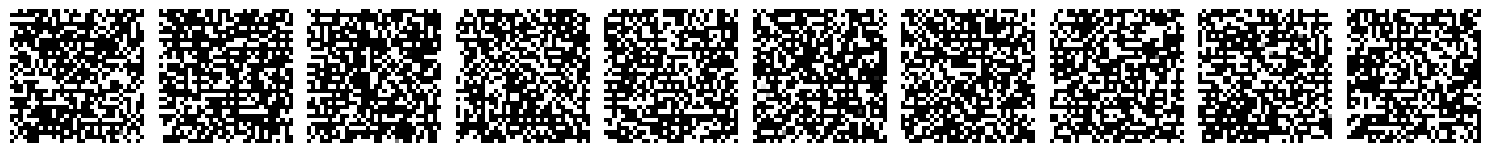

In [ ]:
ddpm.eval()
with torch.inference_mode():
    xh = ddpm.sample(n_sample=10, size=sample.shape, device=device)
    print(xh.shape)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)

In [ ]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epoch = 50
for epoch in range(n_epoch):
  ddpm.train()

  pbar = tqdm(dataloader)
  pbar.set_description("Epoch {:>2d}/{:2d}".format(epoch+1, n_epoch))
  for x, _ in pbar:
    x = x.to(device)

    optimizer.zero_grad()
    loss = ddpm(x)
    loss.backward()
    optimizer.step()

    pbar.set_postfix_str("loss {:.4f}".format(loss.item()))

  ddpm.eval()
  with torch.inference_mode():
    xh = ddpm.sample(n_sample=10, size=x.shape[1:], device=device)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    output_dir = Path("output")
    if not output_dir.exists(): output_dir.mkdir(exist_ok=True, parents=True) 
    draw_images(xh_list, save_path=output_dir/"ddpm_{:03d}.png".format(epoch+1))
    plt.close()
    model_dir = Path("model")
    if not model_dir.exists(): model_dir.mkdir(exist_ok=True, parents=True) 
    torch.save(ddpm.state_dict(), "ddpm.pth")

Epoch 50/50: 100%|██████████| 469/469 [01:11<00:00,  6.58it/s, loss 0.0162]


torch.Size([10, 1, 32, 32])


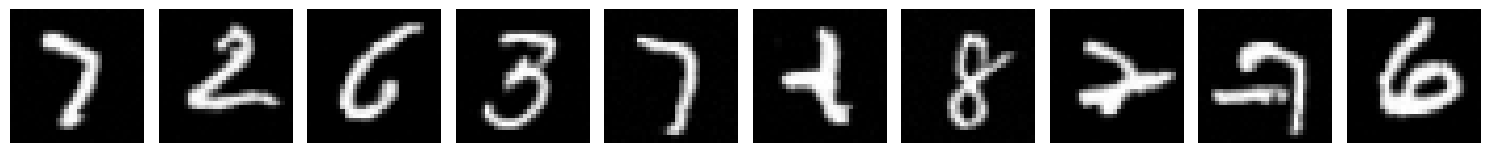

In [ ]:
torch.manual_seed(42)
ddpm.eval()
with torch.inference_mode():
    xh = ddpm.sample(n_sample=10, size=sample.shape, device=device)
    print(xh.shape)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)

torch.Size([10, 1, 32, 32])


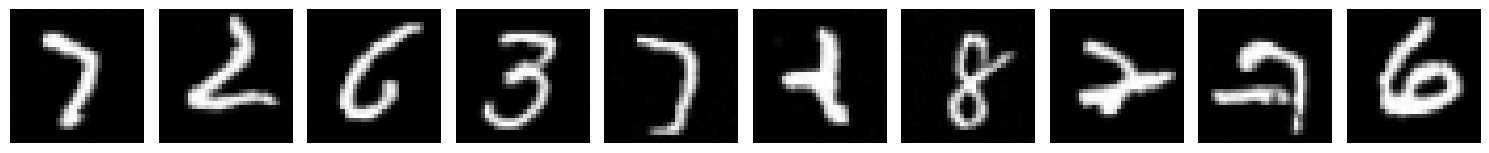

In [ ]:
torch.manual_seed(42)
model = DDPM(eps_model=UNet(1, 1, n_feat=128), betas=(1e-4, 0.02), T=1000).to(device)
model.load_state_dict(torch.load("ddpm.pth", map_location=device, weights_only=True))
model.eval()
with torch.inference_mode():
    xh = model.sample(n_sample=10, size=sample.shape, device=device)
    print(xh.shape)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)